# Standard Input + Mention Pooling

Model Architecture (b) from the paper [Matching the Blanks: Distributional Similarity for Relation Learning](https://arxiv.org/abs/1906.03158) (Soares et al, 2019).

The model takes the text as input (bounded by the `[CLS]` and `[SEP]` tags). For the output, it max pools final hidden layers corresponding to the word pieces in each entity mention, to get two vectors $\mathbf{h_{1}} = MAXPOOL(h_{i}, ..., h_{j})$ and $\mathbf{h_{2}} = MAXPOOL(h_{k}, ..., h_{l})$ where $(i, j)$ and $(k, l)$ represent the token spans for each entity mention. We concatenate these two vectors to get a single relation representation $\mathbf{h} = CONCAT(\mathbf{h_{1}}, \mathbf{h_{2}})$.

## Environment Setup



In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import random
import re
import shutil
import torch
import torch.nn as nn

from datasets import load_dataset, ClassLabel
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim import AdamW

from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix, 
    classification_report, accuracy_score
)
from transformers import (
    AutoConfig, AutoTokenizer, AutoModel, 
    DataCollatorWithPadding, get_scheduler
)
from transformers.modeling_outputs import SequenceClassifierOutput

%matplotlib inline

## Constants

In [3]:
GS_DATA_DIR = "/content/drive/MyDrive/neural-re-data"
DATA_DIR = "./data"

# BASE_MODEL_NAME = "bert-base-cased"
# BASE_MODEL_NAME = "distilbert-base-cased"
BASE_MODEL_NAME = "xlnet-base-cased"

MODEL_DIR = os.path.join(GS_DATA_DIR, "{:s}-scierc-std-mp".format(BASE_MODEL_NAME.split("-")[0]))

MAX_LENGTH = 400

BATCH_SIZE = 16

LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2

NUM_EPOCHS = 5
# NUM_EPOCHS = 1

In [4]:
def set_random_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

set_random_seed(42)

## Data Processing

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls /content/drive/MyDrive/neural-re-data/

bert-scierc-em-cls	   distilbert-scierc-std-mp  xlnet-scierc-em-cls
bert-scierc-std-cls	   raw_data		     xlnet-scierc-std-cls
bert-scierc-std-mp	   test.jsonl		     xlnet-scierc-std-mp
distilbert-scierc-em-cls   train.jsonl
distilbert-scierc-std-cls  val.jsonl


In [7]:
with open(os.path.join(GS_DATA_DIR, "train.jsonl"), "r") as fin:
  for line in fin:
    rec = json.loads(line.strip())
    break

print(json.dumps(rec, indent=2))

{
  "text": " \n A method for  error correction  of  ill-formed input  is described that acquires  dialogue patterns  in typical usage and uses these  patterns  to predict new inputs.  Error correction  is done by strongly biasing  parsing  toward expected  meanings  unless clear evidence from the input shows the current  sentence  is not expected. A  dialogue acquisition and tracking algorithm  is presented along with a description of its  implementation  in a  voice interactive system  . A series of tests are described that show the power of the  error correction methodology  when  stereotypic dialogue  occurs. ",
  "h": {
    "type": "Generic",
    "start": 137,
    "end": 145,
    "span": "patterns"
  },
  "t": {
    "type": "OtherScientificTerm",
    "start": 85,
    "end": 102,
    "span": "dialogue patterns"
  },
  "r": "COREF"
}


In [8]:
def mark_entities_in_text(rec):
  text = rec["text"]
  spans = [(rec["h"]["start"], rec["h"]["end"]),
           (rec["t"]["start"], rec["t"]["end"])]
  spans = sorted(spans, key=operator.itemgetter(0))
  span_pts = [0]
  for start, end in spans:
    span_pts.append(start)
    span_pts.append(end)
  span_pts.append(len(text))
  span_ranges = [(span_pts[i], span_pts[i+1]) for i in range(len(span_pts) - 1)]
  splits = [text[start:end] for start, end in span_ranges]
  splits[1] = " >>" + splits[1] + "<< "
  splits[3] = " >>" + splits[3] + "<< "
  text_em = "".join(splits)
  return text_em


def preprocess_text(rec):
  text_em = mark_entities_in_text(rec)
  text = text_em.replace("\n", " ")
  # text = re.sub(r"([.,;:!?()-])", r" \1 ", text)
  # text = re.sub(r"'s", " 's", text)
  # text = re.sub(r"—", " — ", text)
  text = re.sub(r"\s+", " ", text)
  text = text.strip()
  return text


text = preprocess_text(rec)
text

'A method for error correction of ill-formed input is described that acquires >>dialogue patterns<< in typical usage and uses these >>patterns<< to predict new inputs. Error correction is done by strongly biasing parsing toward expected meanings unless clear evidence from the input shows the current sentence is not expected. A dialogue acquisition and tracking algorithm is presented along with a description of its implementation in a voice interactive system . A series of tests are described that show the power of the error correction methodology when stereotypic dialogue occurs.'

In [9]:
def generate_entity_token_positions(text):
  tokens = text.split()
  starts = [i for i, token in enumerate(tokens) if token.startswith(">>")]
  ends = [i for i, token in enumerate(tokens) if token.endswith("<<")]
  return list(zip(starts, ends))

generate_entity_token_positions(text)

[(12, 13), (20, 20)]

In [10]:
def reformat_json(infile, outfile):
  num_recs = 0
  fout = open(outfile, "w")
  with open(infile, "r") as fin:
    for line in fin:
      rec = json.loads(line.strip())
      text = preprocess_text(rec)
      text_a = " ".join([tokenizer.cls_token, text, tokenizer.sep_token])
      label = rec["r"]
      # extract token spans and remove markers in text
      token_spans = generate_entity_token_positions(text_a)
      text_a = text_a.replace(">>", " ").replace("<<", " ")
      text_a = re.sub("\s+", " ", text_a)
      # if len(token_spans) != 2:
      #   print("text:", text_a)
      #   print("token_spans:", token_spans)
      #   break
      output_rec = { 
        "text": text_a, 
        "token_spans": token_spans, 
        "label_s": label 
      }
      fout.write(json.dumps(output_rec) + "\n")
      num_recs += 1
  print("reformatting {:s} -> {:s} ({:d} records)".format(infile, outfile, num_recs))


os.makedirs(DATA_DIR, exist_ok=True)

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

splits = ["train", "test", "val"]
for split in splits:
  reformat_json(os.path.join(GS_DATA_DIR, "{:s}.jsonl".format(split)),
                os.path.join(DATA_DIR, "{:s}.json".format(split)))

reformatting /content/drive/MyDrive/neural-re-data/train.jsonl -> ./data/train.json (4603 records)
reformatting /content/drive/MyDrive/neural-re-data/test.jsonl -> ./data/test.json (1279 records)
reformatting /content/drive/MyDrive/neural-re-data/val.jsonl -> ./data/val.json (512 records)


## Raw Dataset

In [11]:
data_files = {split: os.path.join(DATA_DIR, "{:s}.json".format(split)) for split in splits}
raw_dataset = load_dataset("json", data_files=data_files)
raw_dataset

Using custom data configuration default-86e6e35f58ff9edc


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-86e6e35f58ff9edc/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'token_spans', 'label_s'],
        num_rows: 4603
    })
    test: Dataset({
        features: ['text', 'token_spans', 'label_s'],
        num_rows: 1279
    })
    val: Dataset({
        features: ['text', 'token_spans', 'label_s'],
        num_rows: 512
    })
})

## Label Mappings

In [12]:
relations = sorted([
  "USED-FOR", "COREF", "CONJUNCTION", "HYPONYM-OF", 
  "EVALUATE-FOR", "PART-OF", "FEATURE-OF", "COMPARE"
])
rel_tags = ClassLabel(names=relations)
label2id = {name: rel_tags.str2int(name) for name in relations}
id2label = {id: rel_tags.int2str(id) for id in range(len(relations))}

# label2id, id2label

## Encoded Dataset

In [13]:
def encode_data(examples):
  tokenized_inputs = tokenizer(examples["text"], 
                               padding=True, truncation=True,
                               max_length=MAX_LENGTH)
  mention_token_ids = []
  token_spans = examples["token_spans"]
  for i, ((e1_start, e1_end), (e2_start, e2_end)) in enumerate(token_spans):
    word_ids = tokenized_inputs.word_ids(i)
    try:
      mention_token_ids.append([
        min([ix for ix, wid in enumerate(word_ids) if wid == e1_start]),
        max([ix+1 for ix, wid in enumerate(word_ids) if wid == e1_end]),
        min([ix for ix, wid in enumerate(word_ids) if wid == e2_start]),
        max([ix+1 for ix, wid in enumerate(word_ids) if wid == e2_end])
      ])
    except ValueError:
      # this seems to be because spans occur outside the max range
      mention_token_ids.append([0, 0, 0, 0])
  tokenized_inputs["mention_token_ids"] = mention_token_ids
  tokenized_inputs["label"] = [label2id[label] for label in examples["label_s"]]
  return tokenized_inputs


encoded = encode_data(raw_dataset["train"][0:1])
encoded.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'mention_token_ids', 'label'])

In [14]:
enc_dataset = (raw_dataset
               .map(encode_data, batched=True, 
                    remove_columns=["text", "label_s", "token_spans"])
               .filter(lambda x: x["mention_token_ids"] != [0, 0, 0, 0])
)
enc_dataset

Parameter 'function'=<function encode_data at 0x7fa90d82dd40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'mention_token_ids', 'label'],
        num_rows: 4598
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'mention_token_ids', 'label'],
        num_rows: 1278
    })
    val: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'mention_token_ids', 'label'],
        num_rows: 510
    })
})

## DataLoader

In [15]:
collate_fn = DataCollatorWithPadding(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(enc_dataset["train"], 
                      shuffle=True, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, enc_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
valid_dl = DataLoader(enc_dataset["val"], 
                      shuffle=False, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, enc_dataset["val"].num_rows, 200).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
test_dl = DataLoader(enc_dataset["test"], 
                     shuffle=False,
                    #  sampler=SubsetRandomSampler(np.random.randint(0, enc_dataset["test"].num_rows, 100).tolist()),
                     batch_size=BATCH_SIZE, 
                     collate_fn=collate_fn)


## Model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class RelationExtractionModelB(nn.Module):
  def __init__(self, base_model_name, num_labels):
    super(RelationExtractionModelB, self).__init__()
    self.num_labels = num_labels
    # body
    config = AutoConfig.from_pretrained(base_model_name)
    self.encoder = AutoModel.from_pretrained(base_model_name, config=config)
    # head
    try:
      self.dropout = nn.Dropout(config.hidden_dropout_prob)
    except AttributeError:
      self.dropout = nn.Dropout(config.dropout)
    self.layer_norm = nn.LayerNorm(config.hidden_size * 2)
    self.linear = nn.Linear(config.hidden_size * 2, self.num_labels)
    
  def forward(self, input_ids, attention_mask, mention_token_ids, 
              token_type_ids=None, labels=None):
    if token_type_ids is None:
      # distilbert does not provide token_type_ids
      outputs = self.encoder(
          input_ids,
          attention_mask=attention_mask,
          output_hidden_states=False).last_hidden_state
    else:
      outputs = self.encoder(
          input_ids,
          token_type_ids=token_type_ids,
          attention_mask=attention_mask,
          output_hidden_states=False).last_hidden_state

    sub_maxpool, obj_maxpool = [], []
    for bid in range(outputs.size(0)):
      sub_span = torch.max(outputs[bid, mention_token_ids[bid, 0]:mention_token_ids[bid, 1], :],
                           dim=0, keepdim=True).values
      obj_span = torch.max(outputs[bid, mention_token_ids[bid, 2]:mention_token_ids[bid, 3], :],
                           dim=0, keepdim=True).values
      sub_maxpool.append(sub_span)
      obj_maxpool.append(obj_span)
  
    sub_emb = torch.cat(sub_maxpool, dim=0)
    obj_emb = torch.cat(obj_maxpool, dim=0)
    rel_input = torch.cat([sub_emb, obj_emb], dim=-1)

    rel_input = self.layer_norm(rel_input)
    rel_input = self.dropout(rel_input)
    logits = self.linear(rel_input)

    if labels is not None:
      loss_fn = nn.CrossEntropyLoss()
      loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
      return SequenceClassifierOutput(loss, logits)
    else:
      return SequenceClassifierOutput(None, logits)


# model = RelationExtractionModelB(BASE_MODEL_NAME, len(relations))
# for batch in train_dl:
#   outputs = model(**batch)
#   break
# print("loss:", outputs.loss, "logits.size:", outputs.logits.size())

## Training

In [18]:
model = RelationExtractionModelB(BASE_MODEL_NAME, len(relations))
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

In [20]:
def compute_accuracy(labels, logits):
  preds_cpu = torch.argmax(logits, dim=-1).cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  return accuracy_score(labels_cpu, preds_cpu)


def do_train(model, train_dl):
  train_loss = 0
  model.train()
  for bid, batch in enumerate(train_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    train_loss += loss.detach().cpu().numpy()
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

  return train_loss


def do_eval(model, eval_dl):
  model.eval()
  eval_loss, eval_score, num_batches = 0, 0, 0
  for bid, batch in enumerate(eval_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    loss = outputs.loss

    eval_loss += loss.detach().cpu().numpy()
    eval_score += compute_accuracy(batch["labels"], outputs.logits)
    num_batches += 1

  eval_score /= num_batches
  return eval_loss, eval_score


def save_checkpoint(model, model_dir, epoch):
  torch.save(model, os.path.join(MODEL_DIR, "ckpt-{:d}".format(epoch)))
  # model.save_pretrained(os.path.join(MODEL_DIR, "ckpt-{:d}".format(epoch)))


def save_training_history(history, model_dir, epoch):
  fhist = open(os.path.join(MODEL_DIR, "history.tsv"), "w")
  for epoch, train_loss, eval_loss, eval_score in history:
    fhist.write("{:d}\t{:.5f}\t{:.5f}\t{:.5f}\n".format(
        epoch, train_loss, eval_loss, eval_score))
  fhist.close()

In [21]:
if os.path.exists(MODEL_DIR):
  shutil.rmtree(MODEL_DIR)
os.makedirs(MODEL_DIR)

history = []

for epoch in range(NUM_EPOCHS):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, valid_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, val-acc: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)

EPOCH 1, train loss: 310.556, val loss: 25.207, val-acc: 0.76953
EPOCH 2, train loss: 147.181, val loss: 22.240, val-acc: 0.77958
EPOCH 3, train loss: 68.574, val loss: 19.471, val-acc: 0.81696
EPOCH 4, train loss: 31.184, val loss: 20.838, val-acc: 0.83650
EPOCH 5, train loss: 18.213, val loss: 21.073, val-acc: 0.83036


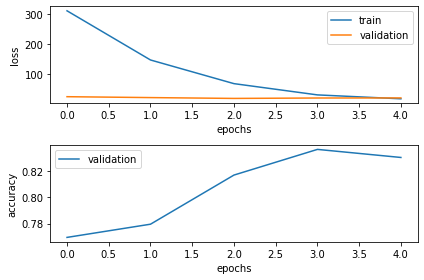

In [22]:
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

## Evaluation

In [23]:
ytrue, ypred = [], []
for batch in test_dl:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)
      predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
      labels = batch["labels"].cpu().numpy()
      ytrue.extend(labels)
      ypred.extend(predictions)

print("test accuracy: {:.3f}".format(accuracy_score(ytrue, ypred)))

test accuracy: 0.841


In [24]:
print(classification_report(ytrue, ypred, target_names=relations))

              precision    recall  f1-score   support

     COMPARE       0.75      0.81      0.78        47
 CONJUNCTION       0.87      0.90      0.88       117
       COREF       0.91      0.86      0.89       335
EVALUATE-FOR       0.74      0.77      0.75        91
  FEATURE-OF       0.62      0.47      0.54        53
  HYPONYM-OF       0.90      0.86      0.88        94
     PART-OF       0.55      0.48      0.51        54
    USED-FOR       0.85      0.91      0.88       487

    accuracy                           0.84      1278
   macro avg       0.77      0.76      0.76      1278
weighted avg       0.84      0.84      0.84      1278



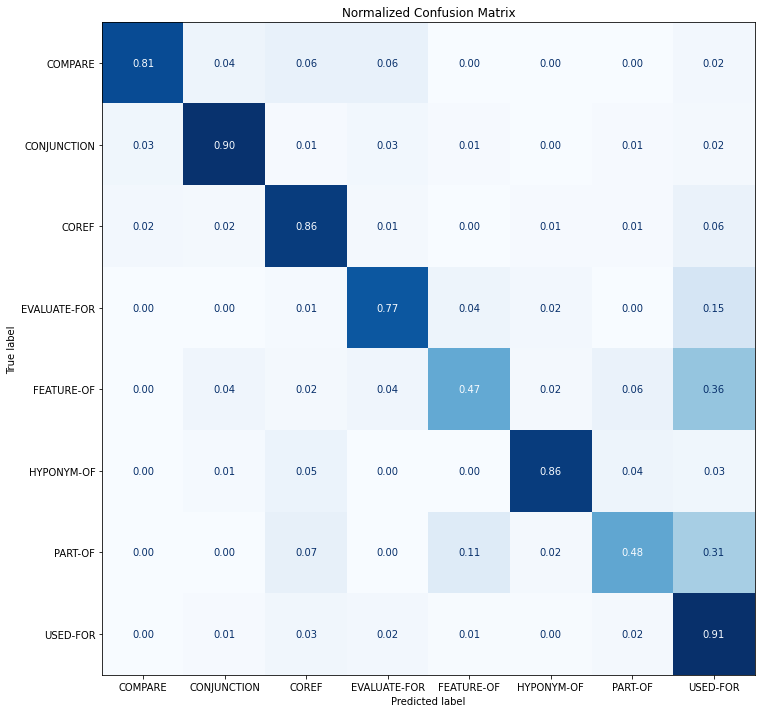

In [25]:
def plot_confusion_matrix(ytrue, ypreds, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  _ = plt.show()


plot_confusion_matrix(ytrue, ypred, relations)